.. index:: Grid construction; Filtered grid views

# FilteredGridView examples

In this example we use `filteredGridView` to filter out parts of a given
grid view.

In [1]:
from ufl import SpatialCoordinate, dot
from dune.grid import cartesianDomain
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.view import filteredGridView
from dune.fem.space import lagrange
from dune.fem.utility import inspectBoundaryIds

Create a host grid view of the underlying grid as usual.
We show the boundary ids and some discrete function - also note the size
of the Lagrange space in this example:

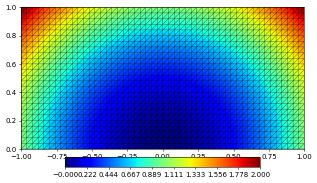

number of dofs: 5151 integral over original domain 1.3333333333333384


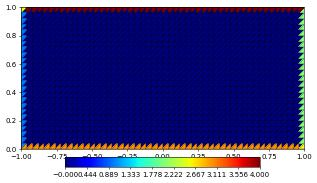

In [2]:
gridView = leafGridView( cartesianDomain([-1,0],[1,1],[50,25]) )
space = lagrange(gridView, order=2)
x = SpatialCoordinate(space)
solution = space.interpolate(dot(x,x),name="solution")
solution.plot(colorbar="horizontal")
print("number of dofs:", solution.size,\
      "integral over original domain",solution.integrate())
inspectBoundaryIds(gridView).plot(colorbar="horizontal")

Now create a `filteredGridView` with a simple callable specifying which element belongs to the new domain.

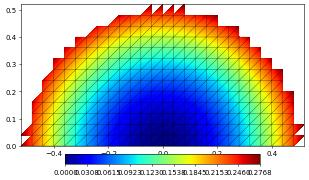

number of dofs: 1053 integral over filtered domain 10 0.04858624000000002


In [3]:
def filterIds(e):
    r = e.geometry.center.two_norm
    if r < 0.5:
        return 10
    elif r < 0.75:
        return 15
    else:
        return 20
filteredView10 = filteredGridView(gridView, filterIds, domainId=10,
                                  useFilteredIndexSet=True)
space10 = lagrange(filteredView10, order=2)
solution10 = space10.interpolate(dot(x,x),name="solution")
solution10.plot(colorbar="horizontal")
print("number of dofs:", solution10.size,\
      "integral over filtered domain 10",solution10.integrate())

.. note::
   The final parameter `useFilteredIndexSet` changes the index set that
   is used over the filtered grid view. The default is `False` so that
   the index set is taken from the underlying grid view. If this is set
   to `True` as here a new index set is generated that only covers the
   the filtered part of the grid. Consequently, the size of the spaces
   over the underlying grid view and the filtered grid view are
   different as shown here.

One can quite easily transfer a grid function from the filtered grid view to
a discrete function over the containing grid or vice versa:
Note that simply using `solution10.interpolate(solution)` will not work
since this method requires the grid views to match:

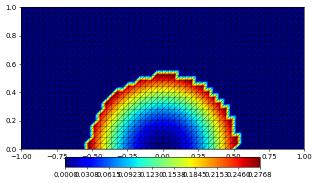

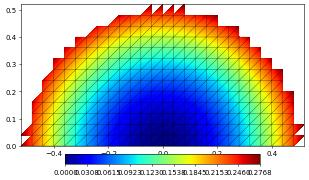

In [4]:
solution.clear()
filteredView10.interpolate(solution10,solution)
solution.plot(colorbar="horizontal")
solution10.clear()
filteredView10.interpolate(solution,solution10)
solution10.plot(colorbar="horizontal")

The boundary ids are set to original ids or to the id of the outside
domain for internal boundaries, i.e., 15 in the current setup:

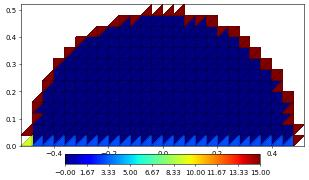

In [5]:
inspectBoundaryIds(filteredView10).plot(colorbar="horizontal")

Filter out a different section of the domain:

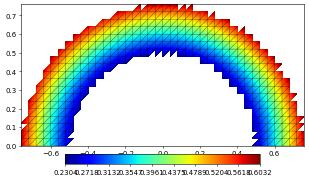

number of dofs: 5151 integral over filtered domain 15 0.2007825066666666


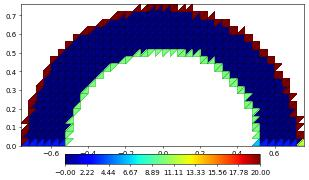

In [6]:
filteredView15 = filteredGridView(gridView, filterIds, domainId=15)
space15 = lagrange(filteredView15, order=2)
x = SpatialCoordinate(space15)
solution15 = space15.interpolate(dot(x,x),name="solution")
solution15.plot(colorbar="horizontal")
print("number of dofs:", solution15.size,\
      "integral over filtered domain 15",solution15.integrate())
inspectBoundaryIds(filteredView15).plot(colorbar="horizontal")

.. note::
   As mentioned already the default is for the index set over the
   filtered grid view to be identical to that of the underlying grid view.
   Consequently, a discrete function over this type of a filtered grid view
   has the same number of degrees of freedom as a discrete
   function in the same type of space over the underlying grid view.

The `space15.interpolate` called above will only set the degrees of
freedom attached to the filtered elements and will contain random
values otherwise. For this reason it makes sense to construct a
discrete function in this case that is guaranteed to be zero
everywhere before performing the interpolation:

In [7]:
solution15 = space15.function(name="solution")
solution15.interpolate(dot(x,x))

A consequence of not changing the index set is that layout of the degrees of freedom of
discrete functions over the same spaces one over the filtered grid view
and the other over the underlying grid view are identical.
This makes the transfer of data very easy to achieve:

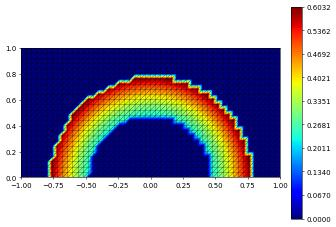

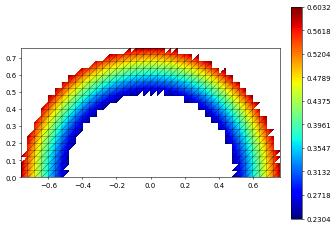

In [8]:
solution.clear()
solution.assign(solution15)  # here the '0' on the domain which is not in the filter is important
solution.plot()
solution15.assign(solution)
solution15.plot()

Finally the outer part of the domain

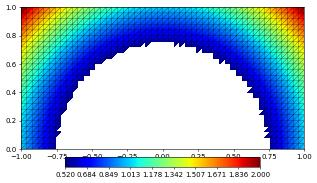

number of dofs: 2979 integral over filtered domain 20 1.0839645866666672


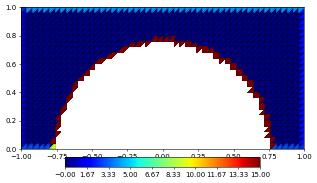

In [9]:
filteredView20 = filteredGridView(gridView, filterIds, domainId=20,
                                  useFilteredIndexSet=True)
space20 = lagrange(filteredView20, order=2)
x = SpatialCoordinate(space20)
solution20 = space20.interpolate(dot(x,x),name="solution")
solution20.plot(colorbar="horizontal")
print("number of dofs:", solution20.size,\
      "integral over filtered domain 20",solution20.integrate())
inspectBoundaryIds(filteredView20).plot(colorbar="horizontal")

Finally we solve a simple linear PDE but with some mixed boundary conditions taken
from one of the [introduction notebooks](concepts_nb.ipynb)

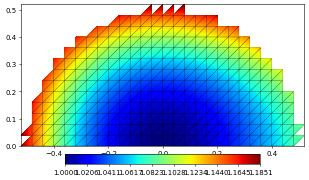

In [10]:
from dune.ufl import DirichletBC
from dune.fem.scheme import galerkin
from ufl import ( TrialFunction, TestFunction, FacetNormal, conditional,
                  div, grad, dx, ds )

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
u     = TrialFunction(space10)
v     = TestFunction(space10)
f     = -div( grad(exact) )
g_N   = grad(exact)
n     = FacetNormal(space10)
b     = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds
a     = dot(grad(u), grad(v)) * dx
dbc   = DirichletBC(space10,exact,x[0]<=1e-8)

scheme = galerkin([a == b, dbc], solver='cg')
scheme.solve(target = solution10)
solution10.plot(colorbar="horizontal")

Let’s compare with the exact solution

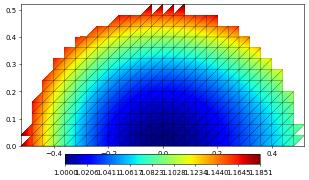

In [11]:
from dune.fem.function import gridFunction
gridFunction(exact,gridView=filteredView10).plot(level=3,colorbar="horizontal")

We already mentioned how the boundary ids are set on internal boundaries,
here is an example elliptic problem with different Dirichlet boundary
conditions set on the two internal boundaries. The small part of the
original boundary at $y=0$ will have trivial Neumann conditions:

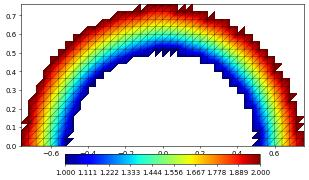

In [12]:
u     = TrialFunction(space15)
v     = TestFunction(space15)
a     = dot(grad(u), grad(v)) * dx
dbc1  = DirichletBC(space15,1,10) # lower internal boundary (domain id there is 10)
dbc2  = DirichletBC(space15,2,20) # upper internal boundary (domain id there is 20)

scheme = galerkin([a == 0, dbc1, dbc2], solver='cg')
scheme.solve(target = solution15)
solution15.plot(colorbar="horizontal")